# this notebook aims to build a Variational Autoencoder with PyTorch
### (Later on maybe a TensorFlow version as well)

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

### We first want to simulate some data, say an ellipse manifold: $x^2/9 + y ^2/4 = 1$ in 2D

## <span style="color:green">Sampling 1</span>

### The sampling below is <span style="color:red">NOT</span> a uniform sample! 
### We first uniform sample from x then find the y with parametrization.
### x is uniform but (x,y) is not
### notice the scarcity of points around $x = 0$; this is expected

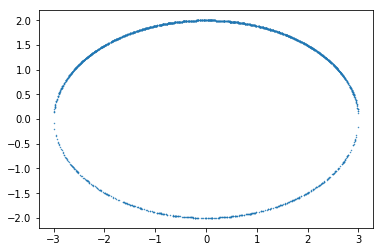

In [56]:
x_sample1 = np.random.uniform(-3,3,2000)
y_sample1 =np.sqrt(4*(1 - x_sample1**2/9))
x_sample2 = np.random.uniform(-3,3,500)
y_sample2 =-np.sqrt(4*(1 - x_sample2**2/9))
x_sample = np.concatenate((x_sample1, x_sample2))
y_sample = np.concatenate((y_sample1, y_sample2))
plt.scatter(x_sample, y_sample , s =0.2)

## <span style="color:green">Sampling 2</span>  (Uniform on the ellipse)

We first sample points from a Gaussian distribution with:<br>
mean $\mu= [0,0]^{T}$ and 
covariance $\Sigma$ = 
$\left[ \begin{array}{cccc}
4 & 0 \\
0 & 9 \\ \end{array} \right]$

Since the covariance matrix is diagonal, this can be simplied as <span style="color:red">indepently</span> sampling from 2 1-D Gaussian

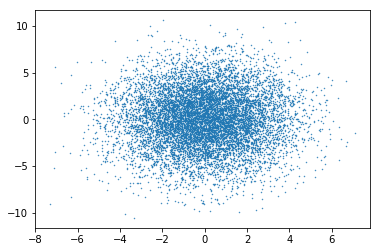

In [60]:
x_sample = np.random.normal(0, 2, 10000)
y_sample = np.random.normal(0, 3, 10000)
plt.scatter(x_sample, y_sample, s = 0.2)

## Then we scale each point to be on the ellipse $x^2/9 + y ^2/4 = 1$
## let $(x_0, y_0)$ be a sample from Gaussian, we want 
## $\lambda$ such that $\frac{(\lambda x_0)^2}{4} + \frac{(\lambda y_0)^2}{9}  = 1$
## easy to show that $\lambda = \frac{1}{\sqrt{x_0^2/9 + y_0^2/4}}$

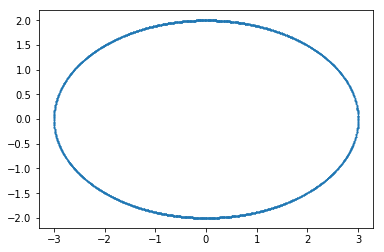

In [62]:
lambda_ = 1/np.sqrt(x_sample**2/9+y_sample**2/4)
x_sample *= lambda_
y_sample *= lambda_
plt.scatter(x_sample, y_sample, s = 0.1)

### We will use sampling method 2 to generate the simulated data moving forward

### Why Sampling 2 works?  <br>
### We want to prove that after the scaling, P(x, y) in 2 ranges with same length are the same <br>
### i.e.,  <span style="color:red">$P(x, y) \in range1 = P(x, y) \in range2$</span>,   if len(range1) = len(range2) <br>
### here range1 and range2 are segments on the ellipse $x^2/9 + y ^2/4 = 1$ 
### now range1 and range2 have their angle ranges $\Omega1, \Omega2$  a point (x,y) gets scaled to be in range1 only if (x,y) lies in the $\Omega1$ angle range (say $[\pi/9, \pi/8]$), at any 'height' c where  $x^2/9 + y ^2/4 = c$ 
### so we can write: <br>
$p(x,y) \in range1$  <br>
<br>
$= \int_{c=0}^{\infty}\int_\color{red}{\theta \in \Omega1}^{} exp(-[x,y]\Sigma^{-1}[x,y]) dc d\theta$ $~~~$ (for all $x^2/9 + y ^2/4 = c ; arctan(y/x) = \theta )$ <br> 
<br>
$= \int_{c=0}^{\infty}\int_\color{red}{\theta \in \Omega2}^{} exp(-[x,y]\Sigma^{-1}[x,y]) dc d\theta$ $~~~$($\forall$ fixed c, Gaussian distribtuion has equal prob for $\Omega1$ and $\Omega2 *$ <br>
<br>
$=p(x,y) \in range2$  

### Proved

*: in other words, if len(range1) = len(range2)  at c = 1, then on a bigger/smaller ellipse (scaled by $\lambda$) we still have len(Range1)  = len(Range2)  <br>    where Range1's angle range is $\Omega1$ and same for Range2

In [133]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

In [67]:
import torch as t

### Define VAE as the official PyTorch tutorial https://github.com/pytorch/examples/tree/master/vae ;
### Main difference is that we add a $\textbf{decode_Gaussian}$ function since our data here  are real-valued in $R^n$ (while in the original example MNIST data are in $\{0,1\}^{784}$
### Also, our input data dimension is 2 but our latent variable is of dimension 10. We make this choice as it yields a good learning capacity for the autoencoder, although usually the latent variable is of dimension much smaller than that of the data

In [1252]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(2, 2)
        self.fc1_1 = nn.Linear(2, 2)
        self.fc21 = nn.Linear(2, 20)
        self.fc22 = nn.Linear(2, 20)
        self.fc3 = nn.Linear(20, 2)
        self.fc3_3 = nn.Linear(2, 2)
        self.fc41 = nn.Linear(2, 2)
        self.fc42 = nn.Linear(2, 2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.training = True

    def encode(self, x):
        h1 = self.fc1(x)
        #h1 = self.relu(self.fc1_1(self.relu(self.fc1(x))))
        h1 = self.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) # mu_z and logvar_z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu) #element-wise
        else:
            return mu

    def decode_sigmoid(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))
    
    def decode_Gaussian(self, z):
        #h3 = self.relu(self.fc3_3(self.relu(self.fc3(z))))
        #h3 = self.fc3(z)
        h3 = self.fc3(z)
        return self.fc41(h3), self.fc42(h3) #mu_x and logvar_x of reconstructed x

    def forward(self, x):
        mu_z, logvar_z = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu_z, logvar_z)
        return self.decode_Gaussian(z), mu_z, logvar_z
        # return mu_z and logvar_z for computing KL-div between q(z|x) and p(z)
    

### reparameterize step:
### we want to maximize the lower-bound of
$log(P_{\theta}(x))\geq E_{q_{\phi}^{}(z|x^i)} log P_{\theta}(x^i|z) -  KL (q_{\phi}(z|x)||p(z))$ $~~~$ First term on RHS is the reconstruction quality; the higher the better per se
### We can't take expectation directly, hence we do a Monte Carlo estimation with just  <span style="color:red">one</span> $\epsilon \sim N(0, I)$ each time, and approximate 
$E_{q_{\phi}^{}(z|x^i)} log P_{\theta}(x^i|z) \approx \frac{1}{L}\Sigma_{l=1}^{L}log P_{\theta}(x^i|z^{l}) = log P_{\theta}(x^i|z^{1})$ <br>

<br>
here we use the reparameterization trick $z^{l} = \mu + \sigma \odot \epsilon^{l}$

#### (pytorch has an easy way to take $\epsilon \sim N(0, I)$ sampling: 
$~~~$ eps = Variable(std.data.new(std.size()).normal_())

In [743]:
##pytorch way to do Normal sampling

# a = np.array([0]*10000)
# a = Variable(t.Tensor(a))
# plt.hist(a.data.new(a.size()).normal_().numpy(),bins = 20)

### In original pytorch example, it uses binary cross entropy as recon_x is in $\{0,1\}^{784}$ after the final sigmoid layer, since MNIST data is $\{0,1\}^{784}$. (i.e. it uses Bernoulli MLP as decoder. see Appendix C from VAE paper)



In [611]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_binary(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


### For our ellipse data, let's change it to good old Gaussian decoder: <br>
$~~~logP_{\theta}(x^i|z^1) $ <br>
<br>
$ = log ~~[{|2\pi \Sigma|^{-1/2}} exp [-1/2 (x^i - \mu_x)^{T}\Sigma^{-1}(x^i - \mu_x)]]$ <br>
<br>
$ = - \frac{1}{2} log |\Sigma| -  \frac{1}{2}(x^i - \mu_x)^{T}\Sigma^{-1}(x^i - \mu_x) + {const}$ <br>
<br>
$ = -\frac{1}{2}\Sigma_j(log \sigma_j^{2}) - \frac{1}{2}\Sigma_{j}[(x^i_j - \mu_{x,j})^2\sigma_{x,j}^{-2}] + const$ <br>

### here $\Sigma$ is diagonal matrix with $[\sigma_{x,1},\sigma_{x,2}, ...]$ on diagonal

In [1034]:
def loss_function_Gaussian(mu_x, logvar_x, x_i, mu_z, logvar_z):
    var_x = logvar_x.exp()
    
    Gaussian_ll = -0.5* t.sum(logvar_x) - 0.5* t.sum(((x_i - mu_x)**2).mul(1/var_x))
    
    KLD = -0.5 * t.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    return -(Gaussian_ll - 0.5 * KLD)  # this is -1(Gaussian_ll - KLD), and we want to maximize the (Gaussian_ll -  KLD) part

In [627]:
# logvar_z = t.Tensor([1,2])
# 1/logvar_z
# t.sum(logvar_z)

In [507]:
# x = t.Tensor([1,2])
# mu = t.Tensor([4,3])
# var_z = t.Tensor([4,9])
# t.sum(((x - mu)**2).mul(var_z))

### wrap the previous Sampling method 2 into a function

In [1076]:
def ellipse_2D(N, mu_x1, mu_x2, a, b):
    x1_sample = np.random.normal(0, a, N)
    x2_sample = np.random.normal(0, b, N)
    lambda_ = 1/np.sqrt(x1_sample**2/(a**2)+x2_sample**2/(b**2))
    x1_sample *= lambda_
    x2_sample *= lambda_
    x1_sample +=mu_x1
    x2_sample +=mu_x2
    return np.concatenate(([x1_sample], [x2_sample])).transpose()


In [1077]:
n = 10000
bsize = 1000
mu_x1= 0
mu_x2 = 0
a = 3
b = 2
log_interval = 50
epochs = 500

In [1078]:
x = t.Tensor(ellipse_2D(N = n, mu_x1 =mu_x1, mu_x2=mu_x2, a=a, b=b))
y = t.Tensor(np.ones(n).reshape(n,1))

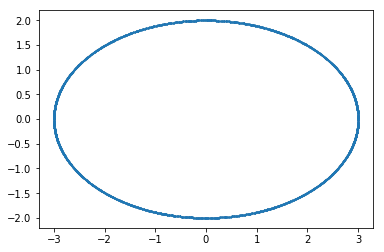

In [1113]:
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

In [1137]:
ellipse_train = torch.utils.data.TensorDataset(x, y)
ellipse_loader = torch.utils.data.DataLoader(ellipse_train, batch_size = bsize) # create your dataloader

In [1131]:
def train(epoch, loader):
    loader = ellipse_loader
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        #just need the data, don't need the dummy label for VAE :)
        data = Variable(data)
        optimizer.zero_grad()
        (mu_x, logvar_x), mu_z, logvar_z = model(data)
        loss = loss_function_Gaussian(mu_x, logvar_x, data, mu_z, logvar_z) #minimize the - loss = maximize lower bound
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader),
                loss.data[0] / len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(loader.dataset)))
    return (-train_loss/len(loader.dataset))  #record average loss at current iteration

In [1151]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_iter = []

### Training

In [1152]:
np.random.seed(seed = 12345)
torch.manual_seed(12345)
epochs = 1000
loss_iter = [0]*epochs
for epoch in range(1, epochs + 1):
    loss_ = train(epoch, ellipse_loader)
    loss_iter[epoch] = loss_
    

Train Epoch: 1 [0/10000 (0%)]	Loss: 12.165873
====> Epoch: 1 Average loss: 11.4206
Train Epoch: 2 [0/10000 (0%)]	Loss: 11.062690
====> Epoch: 2 Average loss: 10.4434
Train Epoch: 3 [0/10000 (0%)]	Loss: 10.083061
====> Epoch: 3 Average loss: 9.5930
Train Epoch: 4 [0/10000 (0%)]	Loss: 9.305840
====> Epoch: 4 Average loss: 8.9056
Train Epoch: 5 [0/10000 (0%)]	Loss: 8.645948
====> Epoch: 5 Average loss: 8.2739
Train Epoch: 6 [0/10000 (0%)]	Loss: 8.011154
====> Epoch: 6 Average loss: 7.6995
Train Epoch: 7 [0/10000 (0%)]	Loss: 7.509191
====> Epoch: 7 Average loss: 7.2136
Train Epoch: 8 [0/10000 (0%)]	Loss: 7.009912
====> Epoch: 8 Average loss: 6.7790
Train Epoch: 9 [0/10000 (0%)]	Loss: 6.564290
====> Epoch: 9 Average loss: 6.3757
Train Epoch: 10 [0/10000 (0%)]	Loss: 6.208246
====> Epoch: 10 Average loss: 6.0213
Train Epoch: 11 [0/10000 (0%)]	Loss: 5.901017
====> Epoch: 11 Average loss: 5.6965
Train Epoch: 12 [0/10000 (0%)]	Loss: 5.533132
====> Epoch: 12 Average loss: 5.4205
Train Epoch: 13 [

====> Epoch: 100 Average loss: 1.8133
Train Epoch: 101 [0/10000 (0%)]	Loss: 1.797297
====> Epoch: 101 Average loss: 1.8151
Train Epoch: 102 [0/10000 (0%)]	Loss: 1.783672
====> Epoch: 102 Average loss: 1.8124
Train Epoch: 103 [0/10000 (0%)]	Loss: 1.760773
====> Epoch: 103 Average loss: 1.7881
Train Epoch: 104 [0/10000 (0%)]	Loss: 1.827820
====> Epoch: 104 Average loss: 1.7941
Train Epoch: 105 [0/10000 (0%)]	Loss: 1.781249
====> Epoch: 105 Average loss: 1.8025
Train Epoch: 106 [0/10000 (0%)]	Loss: 1.788140
====> Epoch: 106 Average loss: 1.7935
Train Epoch: 107 [0/10000 (0%)]	Loss: 1.816720
====> Epoch: 107 Average loss: 1.7898
Train Epoch: 108 [0/10000 (0%)]	Loss: 1.741839
====> Epoch: 108 Average loss: 1.7842
Train Epoch: 109 [0/10000 (0%)]	Loss: 1.814172
====> Epoch: 109 Average loss: 1.7899
Train Epoch: 110 [0/10000 (0%)]	Loss: 1.790723
====> Epoch: 110 Average loss: 1.7808
Train Epoch: 111 [0/10000 (0%)]	Loss: 1.730622
====> Epoch: 111 Average loss: 1.7574
Train Epoch: 112 [0/10000 (

====> Epoch: 196 Average loss: 1.2432
Train Epoch: 197 [0/10000 (0%)]	Loss: 1.238537
====> Epoch: 197 Average loss: 1.2449
Train Epoch: 198 [0/10000 (0%)]	Loss: 1.264197
====> Epoch: 198 Average loss: 1.2396
Train Epoch: 199 [0/10000 (0%)]	Loss: 1.260946
====> Epoch: 199 Average loss: 1.2314
Train Epoch: 200 [0/10000 (0%)]	Loss: 1.237969
====> Epoch: 200 Average loss: 1.2246
Train Epoch: 201 [0/10000 (0%)]	Loss: 1.237763
====> Epoch: 201 Average loss: 1.2298
Train Epoch: 202 [0/10000 (0%)]	Loss: 1.230520
====> Epoch: 202 Average loss: 1.2096
Train Epoch: 203 [0/10000 (0%)]	Loss: 1.164086
====> Epoch: 203 Average loss: 1.1955
Train Epoch: 204 [0/10000 (0%)]	Loss: 1.181503
====> Epoch: 204 Average loss: 1.1921
Train Epoch: 205 [0/10000 (0%)]	Loss: 1.171113
====> Epoch: 205 Average loss: 1.1837
Train Epoch: 206 [0/10000 (0%)]	Loss: 1.179706
====> Epoch: 206 Average loss: 1.1712
Train Epoch: 207 [0/10000 (0%)]	Loss: 1.190749
====> Epoch: 207 Average loss: 1.1667
Train Epoch: 208 [0/10000 (

====> Epoch: 294 Average loss: 0.1909
Train Epoch: 295 [0/10000 (0%)]	Loss: 0.169682
====> Epoch: 295 Average loss: 0.1823
Train Epoch: 296 [0/10000 (0%)]	Loss: 0.139486
====> Epoch: 296 Average loss: 0.1593
Train Epoch: 297 [0/10000 (0%)]	Loss: 0.165108
====> Epoch: 297 Average loss: 0.1467
Train Epoch: 298 [0/10000 (0%)]	Loss: 0.147274
====> Epoch: 298 Average loss: 0.1384
Train Epoch: 299 [0/10000 (0%)]	Loss: 0.120555
====> Epoch: 299 Average loss: 0.1192
Train Epoch: 300 [0/10000 (0%)]	Loss: 0.116365
====> Epoch: 300 Average loss: 0.0960
Train Epoch: 301 [0/10000 (0%)]	Loss: 0.090617
====> Epoch: 301 Average loss: 0.0713
Train Epoch: 302 [0/10000 (0%)]	Loss: 0.056233
====> Epoch: 302 Average loss: 0.0490
Train Epoch: 303 [0/10000 (0%)]	Loss: 0.053478
====> Epoch: 303 Average loss: 0.0374
Train Epoch: 304 [0/10000 (0%)]	Loss: 0.059127
====> Epoch: 304 Average loss: 0.0233
Train Epoch: 305 [0/10000 (0%)]	Loss: -0.006971
====> Epoch: 305 Average loss: -0.0086
Train Epoch: 306 [0/10000

Train Epoch: 391 [0/10000 (0%)]	Loss: -1.240467
====> Epoch: 391 Average loss: -1.2207
Train Epoch: 392 [0/10000 (0%)]	Loss: -1.249269
====> Epoch: 392 Average loss: -1.2525
Train Epoch: 393 [0/10000 (0%)]	Loss: -1.206316
====> Epoch: 393 Average loss: -1.2496
Train Epoch: 394 [0/10000 (0%)]	Loss: -1.289387
====> Epoch: 394 Average loss: -1.2531
Train Epoch: 395 [0/10000 (0%)]	Loss: -1.266106
====> Epoch: 395 Average loss: -1.2798
Train Epoch: 396 [0/10000 (0%)]	Loss: -1.232320
====> Epoch: 396 Average loss: -1.2689
Train Epoch: 397 [0/10000 (0%)]	Loss: -1.269858
====> Epoch: 397 Average loss: -1.2937
Train Epoch: 398 [0/10000 (0%)]	Loss: -1.281846
====> Epoch: 398 Average loss: -1.3032
Train Epoch: 399 [0/10000 (0%)]	Loss: -1.277773
====> Epoch: 399 Average loss: -1.3071
Train Epoch: 400 [0/10000 (0%)]	Loss: -1.250242
====> Epoch: 400 Average loss: -1.3088
Train Epoch: 401 [0/10000 (0%)]	Loss: -1.297989
====> Epoch: 401 Average loss: -1.3393
Train Epoch: 402 [0/10000 (0%)]	Loss: -1.36

====> Epoch: 486 Average loss: -1.8968
Train Epoch: 487 [0/10000 (0%)]	Loss: -1.887615
====> Epoch: 487 Average loss: -2.0111
Train Epoch: 488 [0/10000 (0%)]	Loss: -2.081561
====> Epoch: 488 Average loss: -2.0460
Train Epoch: 489 [0/10000 (0%)]	Loss: -2.012738
====> Epoch: 489 Average loss: -1.9878
Train Epoch: 490 [0/10000 (0%)]	Loss: -1.963488
====> Epoch: 490 Average loss: -1.8531
Train Epoch: 491 [0/10000 (0%)]	Loss: -1.921964
====> Epoch: 491 Average loss: -1.8934
Train Epoch: 492 [0/10000 (0%)]	Loss: -1.965213
====> Epoch: 492 Average loss: -1.9856
Train Epoch: 493 [0/10000 (0%)]	Loss: -1.892112
====> Epoch: 493 Average loss: -2.0145
Train Epoch: 494 [0/10000 (0%)]	Loss: -1.957709
====> Epoch: 494 Average loss: -2.0541
Train Epoch: 495 [0/10000 (0%)]	Loss: -2.066694
====> Epoch: 495 Average loss: -2.0608
Train Epoch: 496 [0/10000 (0%)]	Loss: -2.067738
====> Epoch: 496 Average loss: -2.0273
Train Epoch: 497 [0/10000 (0%)]	Loss: -1.815132
====> Epoch: 497 Average loss: -1.9802
Trai

====> Epoch: 582 Average loss: -2.4340
Train Epoch: 583 [0/10000 (0%)]	Loss: -2.440511
====> Epoch: 583 Average loss: -2.4162
Train Epoch: 584 [0/10000 (0%)]	Loss: -2.386499
====> Epoch: 584 Average loss: -2.3802
Train Epoch: 585 [0/10000 (0%)]	Loss: -2.417421
====> Epoch: 585 Average loss: -2.2969
Train Epoch: 586 [0/10000 (0%)]	Loss: -2.445891
====> Epoch: 586 Average loss: -2.4400
Train Epoch: 587 [0/10000 (0%)]	Loss: -2.486313
====> Epoch: 587 Average loss: -2.4864
Train Epoch: 588 [0/10000 (0%)]	Loss: -2.392816
====> Epoch: 588 Average loss: -2.4885
Train Epoch: 589 [0/10000 (0%)]	Loss: -2.459017
====> Epoch: 589 Average loss: -2.4990
Train Epoch: 590 [0/10000 (0%)]	Loss: -2.460669
====> Epoch: 590 Average loss: -2.4997
Train Epoch: 591 [0/10000 (0%)]	Loss: -2.459711
====> Epoch: 591 Average loss: -2.4258
Train Epoch: 592 [0/10000 (0%)]	Loss: -2.164561
====> Epoch: 592 Average loss: -2.2190
Train Epoch: 593 [0/10000 (0%)]	Loss: -2.331125
====> Epoch: 593 Average loss: -2.4018
Trai

====> Epoch: 678 Average loss: -2.3296
Train Epoch: 679 [0/10000 (0%)]	Loss: -2.609956
====> Epoch: 679 Average loss: -2.4782
Train Epoch: 680 [0/10000 (0%)]	Loss: -2.583229
====> Epoch: 680 Average loss: -2.5488
Train Epoch: 681 [0/10000 (0%)]	Loss: -2.583295
====> Epoch: 681 Average loss: -2.6970
Train Epoch: 682 [0/10000 (0%)]	Loss: -2.687508
====> Epoch: 682 Average loss: -2.6856
Train Epoch: 683 [0/10000 (0%)]	Loss: -2.705285
====> Epoch: 683 Average loss: -2.7382
Train Epoch: 684 [0/10000 (0%)]	Loss: -2.762034
====> Epoch: 684 Average loss: -2.7699
Train Epoch: 685 [0/10000 (0%)]	Loss: -2.686654
====> Epoch: 685 Average loss: -2.7552
Train Epoch: 686 [0/10000 (0%)]	Loss: -2.771867
====> Epoch: 686 Average loss: -2.8187
Train Epoch: 687 [0/10000 (0%)]	Loss: -2.756606
====> Epoch: 687 Average loss: -2.7605
Train Epoch: 688 [0/10000 (0%)]	Loss: -2.626029
====> Epoch: 688 Average loss: -2.5359
Train Epoch: 689 [0/10000 (0%)]	Loss: -2.049810
====> Epoch: 689 Average loss: -2.4975
Trai

====> Epoch: 774 Average loss: -2.9123
Train Epoch: 775 [0/10000 (0%)]	Loss: -2.936675
====> Epoch: 775 Average loss: -2.9315
Train Epoch: 776 [0/10000 (0%)]	Loss: -2.929437
====> Epoch: 776 Average loss: -2.9899
Train Epoch: 777 [0/10000 (0%)]	Loss: -2.963330
====> Epoch: 777 Average loss: -2.9706
Train Epoch: 778 [0/10000 (0%)]	Loss: -2.793014
====> Epoch: 778 Average loss: -2.7297
Train Epoch: 779 [0/10000 (0%)]	Loss: -2.474285
====> Epoch: 779 Average loss: -2.5557
Train Epoch: 780 [0/10000 (0%)]	Loss: -2.561853
====> Epoch: 780 Average loss: -2.7149
Train Epoch: 781 [0/10000 (0%)]	Loss: -2.762355
====> Epoch: 781 Average loss: -2.7514
Train Epoch: 782 [0/10000 (0%)]	Loss: -2.589364
====> Epoch: 782 Average loss: -2.7811
Train Epoch: 783 [0/10000 (0%)]	Loss: -2.826537
====> Epoch: 783 Average loss: -2.8906
Train Epoch: 784 [0/10000 (0%)]	Loss: -2.800946
====> Epoch: 784 Average loss: -2.8440
Train Epoch: 785 [0/10000 (0%)]	Loss: -2.825152
====> Epoch: 785 Average loss: -2.9086
Trai

====> Epoch: 869 Average loss: -3.1295
Train Epoch: 870 [0/10000 (0%)]	Loss: -3.147252
====> Epoch: 870 Average loss: -3.0440
Train Epoch: 871 [0/10000 (0%)]	Loss: -3.068173
====> Epoch: 871 Average loss: -2.9763
Train Epoch: 872 [0/10000 (0%)]	Loss: -3.033252
====> Epoch: 872 Average loss: -2.3633
Train Epoch: 873 [0/10000 (0%)]	Loss: -2.337172
====> Epoch: 873 Average loss: -2.3420
Train Epoch: 874 [0/10000 (0%)]	Loss: -3.028710
====> Epoch: 874 Average loss: -2.7640
Train Epoch: 875 [0/10000 (0%)]	Loss: -2.946245
====> Epoch: 875 Average loss: -2.6417
Train Epoch: 876 [0/10000 (0%)]	Loss: -3.001798
====> Epoch: 876 Average loss: -2.9209
Train Epoch: 877 [0/10000 (0%)]	Loss: -2.910277
====> Epoch: 877 Average loss: -3.0392
Train Epoch: 878 [0/10000 (0%)]	Loss: -3.051225
====> Epoch: 878 Average loss: -3.1255
Train Epoch: 879 [0/10000 (0%)]	Loss: -3.105228
====> Epoch: 879 Average loss: -3.1433
Train Epoch: 880 [0/10000 (0%)]	Loss: -3.094194
====> Epoch: 880 Average loss: -3.1130
Trai

====> Epoch: 965 Average loss: -3.1421
Train Epoch: 966 [0/10000 (0%)]	Loss: -3.137002
====> Epoch: 966 Average loss: -3.2127
Train Epoch: 967 [0/10000 (0%)]	Loss: -3.143000
====> Epoch: 967 Average loss: -3.2525
Train Epoch: 968 [0/10000 (0%)]	Loss: -3.195085
====> Epoch: 968 Average loss: -3.2448
Train Epoch: 969 [0/10000 (0%)]	Loss: -3.178117
====> Epoch: 969 Average loss: -3.3004
Train Epoch: 970 [0/10000 (0%)]	Loss: -3.274073
====> Epoch: 970 Average loss: -3.2293
Train Epoch: 971 [0/10000 (0%)]	Loss: -3.248022
====> Epoch: 971 Average loss: -3.2925
Train Epoch: 972 [0/10000 (0%)]	Loss: -3.151869
====> Epoch: 972 Average loss: -3.2174
Train Epoch: 973 [0/10000 (0%)]	Loss: -3.120992
====> Epoch: 973 Average loss: -2.9691
Train Epoch: 974 [0/10000 (0%)]	Loss: -2.628131
====> Epoch: 974 Average loss: -2.4179
Train Epoch: 975 [0/10000 (0%)]	Loss: -2.733747
====> Epoch: 975 Average loss: -2.6706
Train Epoch: 976 [0/10000 (0%)]	Loss: -2.975327
====> Epoch: 976 Average loss: -2.8874
Trai

### The negative loss function over iterations

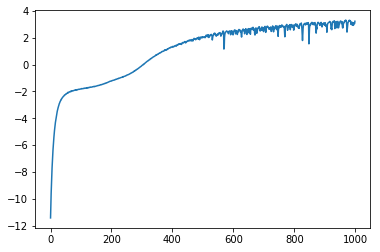

In [1156]:
plt.plot(range(epochs),loss_iter)

### We want to generate new data with the trained autoencoder; we compare two methods below.

### generate new data via $p(x) = \int p(z)~p_{\theta}(x|z)~dz$

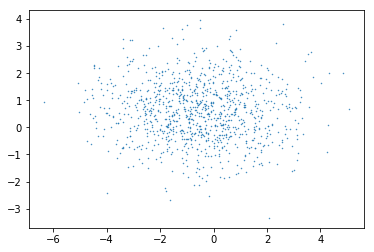

In [1158]:
sample = Variable(t.randn(1000, 20))
sample = model.decode_Gaussian(sample)
std = sample[1].exp_().sqrt()
sample_x1 = np.random.normal(0,1,1000) * std.data.numpy()[:,0] + sample[0].data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,1000) * std.data.numpy()[:,1] + sample[0].data.numpy().transpose()[1]
plt.scatter(sample_x1,sample_x2,s=0.2)
#plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

### generate new data via $p(x^{new}|x) = \int p(x^{new}|z)~p_{\theta}(z|x)~dz$

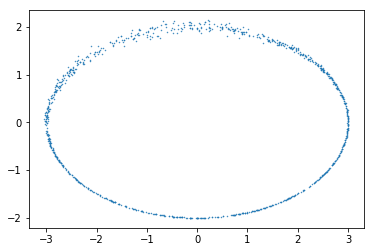

In [1157]:
for batch_idx, (data, _) in enumerate(ellipse_loader):
    if batch_idx ==0:
        data = Variable(data)
        (mu_x, logvar_x), mu_z, logvar_z = model(data)
std = logvar_x.exp_().sqrt()
sample_x1 = np.random.normal(0,1,bsize) * std.data.numpy()[:,0] + mu_x.data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,bsize) * std.data.numpy()[:,1] + mu_x.data.numpy().transpose()[1]
plt.scatter(sample_x1,sample_x2,s=0.2)
#plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)
    

### The second method yields better reconstructed data, although the authors and other tutorials generate new data using the first method. I will leave this open for now

### Next we build a VAE to learn data coming from a Gaussian Mixture Model (GMM) in 2D. 

In [1159]:
def GMM_2D(N, mu_x1, mu_x2, a, b):
    x1_sample = np.random.normal(0, a, N)
    x2_sample = np.random.normal(0, b, N)
    lambda_ = 1/np.sqrt(x1_sample**2/(a**2)+x2_sample**2/(b**2))
    x1_sample +=mu_x1
    x2_sample +=mu_x2
    return np.concatenate(([x1_sample], [x2_sample])).transpose()



In [1160]:
n = 5000

x_c1 = t.Tensor(GMM_2D(N = n, mu_x1 = -6 , mu_x2= -6, a=3, b=2))
x_c2= t.Tensor(GMM_2D(N = n, mu_x1 = 6, mu_x2=  6, a=2, b=3))
y_c1 = t.Tensor(np.ones(n).reshape(n,1))
y_c2 = t.Tensor(np.ones(n).reshape(n,1))
x = t.cat((x_c1,x_c2))
y = t.cat((y_c1,y_c2))

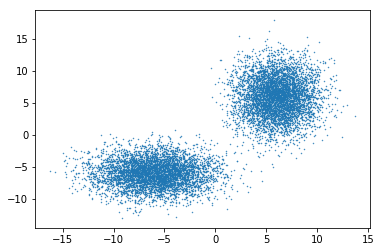

In [1211]:
## the data
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

In [1253]:
np.random.seed(seed = 12345)
torch.manual_seed(12345)

In [1254]:
GMM_train = torch.utils.data.TensorDataset(x, y)
GMM_loader = torch.utils.data.DataLoader(GMM_train, batch_size = bsize, shuffle = True) # create your dataloader

In [1255]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [1256]:
epochs = 1500
loss_iter = [0]*epochs
for epoch in range(1, epochs + 1):
    loss_ = train(epoch = epoch,loader = GMM_loader)
    loss_iter[epoch - 1] = loss_

Train Epoch: 1 [0/10000 (0%)]	Loss: 7.620846
====> Epoch: 1 Average loss: 7.0584
Train Epoch: 2 [0/10000 (0%)]	Loss: 6.916771
====> Epoch: 2 Average loss: 6.5789
Train Epoch: 3 [0/10000 (0%)]	Loss: 6.478376
====> Epoch: 3 Average loss: 6.1468
Train Epoch: 4 [0/10000 (0%)]	Loss: 6.218108
====> Epoch: 4 Average loss: 5.8002
Train Epoch: 5 [0/10000 (0%)]	Loss: 5.830757
====> Epoch: 5 Average loss: 5.5115
Train Epoch: 6 [0/10000 (0%)]	Loss: 5.470704
====> Epoch: 6 Average loss: 5.2771
Train Epoch: 7 [0/10000 (0%)]	Loss: 5.249500
====> Epoch: 7 Average loss: 5.0561
Train Epoch: 8 [0/10000 (0%)]	Loss: 5.078196
====> Epoch: 8 Average loss: 4.8800
Train Epoch: 9 [0/10000 (0%)]	Loss: 4.891940
====> Epoch: 9 Average loss: 4.7088
Train Epoch: 10 [0/10000 (0%)]	Loss: 4.655766
====> Epoch: 10 Average loss: 4.5104
Train Epoch: 11 [0/10000 (0%)]	Loss: 4.530286
====> Epoch: 11 Average loss: 4.3860
Train Epoch: 12 [0/10000 (0%)]	Loss: 4.358715
====> Epoch: 12 Average loss: 4.2577
Train Epoch: 13 [0/100

====> Epoch: 100 Average loss: 2.0143
Train Epoch: 101 [0/10000 (0%)]	Loss: 1.975943
====> Epoch: 101 Average loss: 2.0188
Train Epoch: 102 [0/10000 (0%)]	Loss: 2.032235
====> Epoch: 102 Average loss: 2.0260
Train Epoch: 103 [0/10000 (0%)]	Loss: 2.016942
====> Epoch: 103 Average loss: 2.0142
Train Epoch: 104 [0/10000 (0%)]	Loss: 1.997272
====> Epoch: 104 Average loss: 2.0081
Train Epoch: 105 [0/10000 (0%)]	Loss: 1.993925
====> Epoch: 105 Average loss: 2.0108
Train Epoch: 106 [0/10000 (0%)]	Loss: 2.055227
====> Epoch: 106 Average loss: 2.0031
Train Epoch: 107 [0/10000 (0%)]	Loss: 1.968783
====> Epoch: 107 Average loss: 2.0046
Train Epoch: 108 [0/10000 (0%)]	Loss: 2.016991
====> Epoch: 108 Average loss: 2.0064
Train Epoch: 109 [0/10000 (0%)]	Loss: 2.014534
====> Epoch: 109 Average loss: 1.9980
Train Epoch: 110 [0/10000 (0%)]	Loss: 2.006864
====> Epoch: 110 Average loss: 1.9910
Train Epoch: 111 [0/10000 (0%)]	Loss: 1.984632
====> Epoch: 111 Average loss: 1.9955
Train Epoch: 112 [0/10000 (

====> Epoch: 197 Average loss: 1.7190
Train Epoch: 198 [0/10000 (0%)]	Loss: 1.733399
====> Epoch: 198 Average loss: 1.7260
Train Epoch: 199 [0/10000 (0%)]	Loss: 1.685697
====> Epoch: 199 Average loss: 1.7099
Train Epoch: 200 [0/10000 (0%)]	Loss: 1.692343
====> Epoch: 200 Average loss: 1.7054
Train Epoch: 201 [0/10000 (0%)]	Loss: 1.674195
====> Epoch: 201 Average loss: 1.7076
Train Epoch: 202 [0/10000 (0%)]	Loss: 1.679307
====> Epoch: 202 Average loss: 1.7010
Train Epoch: 203 [0/10000 (0%)]	Loss: 1.677607
====> Epoch: 203 Average loss: 1.6969
Train Epoch: 204 [0/10000 (0%)]	Loss: 1.710554
====> Epoch: 204 Average loss: 1.6906
Train Epoch: 205 [0/10000 (0%)]	Loss: 1.704751
====> Epoch: 205 Average loss: 1.6946
Train Epoch: 206 [0/10000 (0%)]	Loss: 1.702844
====> Epoch: 206 Average loss: 1.6957
Train Epoch: 207 [0/10000 (0%)]	Loss: 1.690286
====> Epoch: 207 Average loss: 1.6824
Train Epoch: 208 [0/10000 (0%)]	Loss: 1.675880
====> Epoch: 208 Average loss: 1.6802
Train Epoch: 209 [0/10000 (

====> Epoch: 294 Average loss: 1.4064
Train Epoch: 295 [0/10000 (0%)]	Loss: 1.409156
====> Epoch: 295 Average loss: 1.4027
Train Epoch: 296 [0/10000 (0%)]	Loss: 1.382679
====> Epoch: 296 Average loss: 1.3966
Train Epoch: 297 [0/10000 (0%)]	Loss: 1.381026
====> Epoch: 297 Average loss: 1.3996
Train Epoch: 298 [0/10000 (0%)]	Loss: 1.376955
====> Epoch: 298 Average loss: 1.3930
Train Epoch: 299 [0/10000 (0%)]	Loss: 1.367718
====> Epoch: 299 Average loss: 1.3836
Train Epoch: 300 [0/10000 (0%)]	Loss: 1.369241
====> Epoch: 300 Average loss: 1.3859
Train Epoch: 301 [0/10000 (0%)]	Loss: 1.372920
====> Epoch: 301 Average loss: 1.3773
Train Epoch: 302 [0/10000 (0%)]	Loss: 1.372787
====> Epoch: 302 Average loss: 1.3805
Train Epoch: 303 [0/10000 (0%)]	Loss: 1.380158
====> Epoch: 303 Average loss: 1.3753
Train Epoch: 304 [0/10000 (0%)]	Loss: 1.361662
====> Epoch: 304 Average loss: 1.3668
Train Epoch: 305 [0/10000 (0%)]	Loss: 1.359079
====> Epoch: 305 Average loss: 1.3632
Train Epoch: 306 [0/10000 (

Train Epoch: 393 [0/10000 (0%)]	Loss: 0.701700
====> Epoch: 393 Average loss: 0.7209
Train Epoch: 394 [0/10000 (0%)]	Loss: 0.740825
====> Epoch: 394 Average loss: 0.7063
Train Epoch: 395 [0/10000 (0%)]	Loss: 0.682012
====> Epoch: 395 Average loss: 0.6895
Train Epoch: 396 [0/10000 (0%)]	Loss: 0.667845
====> Epoch: 396 Average loss: 0.6818
Train Epoch: 397 [0/10000 (0%)]	Loss: 0.659654
====> Epoch: 397 Average loss: 0.6684
Train Epoch: 398 [0/10000 (0%)]	Loss: 0.682080
====> Epoch: 398 Average loss: 0.6648
Train Epoch: 399 [0/10000 (0%)]	Loss: 0.644585
====> Epoch: 399 Average loss: 0.6537
Train Epoch: 400 [0/10000 (0%)]	Loss: 0.638172
====> Epoch: 400 Average loss: 0.6438
Train Epoch: 401 [0/10000 (0%)]	Loss: 0.605958
====> Epoch: 401 Average loss: 0.6198
Train Epoch: 402 [0/10000 (0%)]	Loss: 0.602731
====> Epoch: 402 Average loss: 0.6156
Train Epoch: 403 [0/10000 (0%)]	Loss: 0.606708
====> Epoch: 403 Average loss: 0.6081
Train Epoch: 404 [0/10000 (0%)]	Loss: 0.620427
====> Epoch: 404 A

====> Epoch: 490 Average loss: -0.1387
Train Epoch: 491 [0/10000 (0%)]	Loss: -0.133125
====> Epoch: 491 Average loss: -0.1626
Train Epoch: 492 [0/10000 (0%)]	Loss: -0.176089
====> Epoch: 492 Average loss: -0.1659
Train Epoch: 493 [0/10000 (0%)]	Loss: -0.161156
====> Epoch: 493 Average loss: -0.1615
Train Epoch: 494 [0/10000 (0%)]	Loss: -0.105054
====> Epoch: 494 Average loss: -0.1457
Train Epoch: 495 [0/10000 (0%)]	Loss: -0.201458
====> Epoch: 495 Average loss: -0.1876
Train Epoch: 496 [0/10000 (0%)]	Loss: -0.196813
====> Epoch: 496 Average loss: -0.1917
Train Epoch: 497 [0/10000 (0%)]	Loss: -0.169252
====> Epoch: 497 Average loss: -0.1937
Train Epoch: 498 [0/10000 (0%)]	Loss: -0.210630
====> Epoch: 498 Average loss: -0.1987
Train Epoch: 499 [0/10000 (0%)]	Loss: -0.215276
====> Epoch: 499 Average loss: -0.2106
Train Epoch: 500 [0/10000 (0%)]	Loss: -0.264210
====> Epoch: 500 Average loss: -0.2308
Train Epoch: 501 [0/10000 (0%)]	Loss: -0.194472
====> Epoch: 501 Average loss: -0.2159
Trai

====> Epoch: 587 Average loss: -0.6043
Train Epoch: 588 [0/10000 (0%)]	Loss: -0.630077
====> Epoch: 588 Average loss: -0.6024
Train Epoch: 589 [0/10000 (0%)]	Loss: -0.540820
====> Epoch: 589 Average loss: -0.5860
Train Epoch: 590 [0/10000 (0%)]	Loss: -0.627831
====> Epoch: 590 Average loss: -0.6405
Train Epoch: 591 [0/10000 (0%)]	Loss: -0.655555
====> Epoch: 591 Average loss: -0.6325
Train Epoch: 592 [0/10000 (0%)]	Loss: -0.632557
====> Epoch: 592 Average loss: -0.6493
Train Epoch: 593 [0/10000 (0%)]	Loss: -0.633631
====> Epoch: 593 Average loss: -0.6254
Train Epoch: 594 [0/10000 (0%)]	Loss: -0.621978
====> Epoch: 594 Average loss: -0.6336
Train Epoch: 595 [0/10000 (0%)]	Loss: -0.635266
====> Epoch: 595 Average loss: -0.6401
Train Epoch: 596 [0/10000 (0%)]	Loss: -0.623840
====> Epoch: 596 Average loss: -0.6233
Train Epoch: 597 [0/10000 (0%)]	Loss: -0.617249
====> Epoch: 597 Average loss: -0.6244
Train Epoch: 598 [0/10000 (0%)]	Loss: -0.633404
====> Epoch: 598 Average loss: -0.6694
Trai

Train Epoch: 684 [0/10000 (0%)]	Loss: -0.779521
====> Epoch: 684 Average loss: -0.8147
Train Epoch: 685 [0/10000 (0%)]	Loss: -0.886757
====> Epoch: 685 Average loss: -0.8700
Train Epoch: 686 [0/10000 (0%)]	Loss: -0.889424
====> Epoch: 686 Average loss: -0.8487
Train Epoch: 687 [0/10000 (0%)]	Loss: -0.811887
====> Epoch: 687 Average loss: -0.8165
Train Epoch: 688 [0/10000 (0%)]	Loss: -0.814702
====> Epoch: 688 Average loss: -0.8328
Train Epoch: 689 [0/10000 (0%)]	Loss: -0.820722
====> Epoch: 689 Average loss: -0.8338
Train Epoch: 690 [0/10000 (0%)]	Loss: -0.869025
====> Epoch: 690 Average loss: -0.8296
Train Epoch: 691 [0/10000 (0%)]	Loss: -0.808175
====> Epoch: 691 Average loss: -0.8371
Train Epoch: 692 [0/10000 (0%)]	Loss: -0.854309
====> Epoch: 692 Average loss: -0.8033
Train Epoch: 693 [0/10000 (0%)]	Loss: -0.864096
====> Epoch: 693 Average loss: -0.8534
Train Epoch: 694 [0/10000 (0%)]	Loss: -0.842879
====> Epoch: 694 Average loss: -0.8534
Train Epoch: 695 [0/10000 (0%)]	Loss: -0.88

====> Epoch: 778 Average loss: -0.9200
Train Epoch: 779 [0/10000 (0%)]	Loss: -0.964632
====> Epoch: 779 Average loss: -0.9367
Train Epoch: 780 [0/10000 (0%)]	Loss: -0.892922
====> Epoch: 780 Average loss: -0.8689
Train Epoch: 781 [0/10000 (0%)]	Loss: -0.953941
====> Epoch: 781 Average loss: -0.9320
Train Epoch: 782 [0/10000 (0%)]	Loss: -0.991187
====> Epoch: 782 Average loss: -0.9598
Train Epoch: 783 [0/10000 (0%)]	Loss: -0.937408
====> Epoch: 783 Average loss: -0.8696
Train Epoch: 784 [0/10000 (0%)]	Loss: -0.957953
====> Epoch: 784 Average loss: -0.9093
Train Epoch: 785 [0/10000 (0%)]	Loss: -0.965063
====> Epoch: 785 Average loss: -0.9398
Train Epoch: 786 [0/10000 (0%)]	Loss: -0.880792
====> Epoch: 786 Average loss: -0.9205
Train Epoch: 787 [0/10000 (0%)]	Loss: -0.946202
====> Epoch: 787 Average loss: -0.9411
Train Epoch: 788 [0/10000 (0%)]	Loss: -0.905477
====> Epoch: 788 Average loss: -0.8985
Train Epoch: 789 [0/10000 (0%)]	Loss: -0.982900
====> Epoch: 789 Average loss: -0.9616
Trai

Train Epoch: 874 [0/10000 (0%)]	Loss: -0.970554
====> Epoch: 874 Average loss: -0.9649
Train Epoch: 875 [0/10000 (0%)]	Loss: -0.954624
====> Epoch: 875 Average loss: -0.9847
Train Epoch: 876 [0/10000 (0%)]	Loss: -1.029103
====> Epoch: 876 Average loss: -0.9838
Train Epoch: 877 [0/10000 (0%)]	Loss: -0.988530
====> Epoch: 877 Average loss: -0.9208
Train Epoch: 878 [0/10000 (0%)]	Loss: -0.958033
====> Epoch: 878 Average loss: -0.9545
Train Epoch: 879 [0/10000 (0%)]	Loss: -0.982561
====> Epoch: 879 Average loss: -0.9267
Train Epoch: 880 [0/10000 (0%)]	Loss: -0.989219
====> Epoch: 880 Average loss: -0.9204
Train Epoch: 881 [0/10000 (0%)]	Loss: -0.878780
====> Epoch: 881 Average loss: -0.8709
Train Epoch: 882 [0/10000 (0%)]	Loss: -0.925513
====> Epoch: 882 Average loss: -0.9497
Train Epoch: 883 [0/10000 (0%)]	Loss: -0.984769
====> Epoch: 883 Average loss: -0.9099
Train Epoch: 884 [0/10000 (0%)]	Loss: -0.946656
====> Epoch: 884 Average loss: -0.9587
Train Epoch: 885 [0/10000 (0%)]	Loss: -0.98

====> Epoch: 968 Average loss: -0.9789
Train Epoch: 969 [0/10000 (0%)]	Loss: -0.964080
====> Epoch: 969 Average loss: -0.9494
Train Epoch: 970 [0/10000 (0%)]	Loss: -0.896595
====> Epoch: 970 Average loss: -0.9259
Train Epoch: 971 [0/10000 (0%)]	Loss: -0.986809
====> Epoch: 971 Average loss: -0.9748
Train Epoch: 972 [0/10000 (0%)]	Loss: -0.974735
====> Epoch: 972 Average loss: -0.9569
Train Epoch: 973 [0/10000 (0%)]	Loss: -0.847157
====> Epoch: 973 Average loss: -0.9321
Train Epoch: 974 [0/10000 (0%)]	Loss: -0.982656
====> Epoch: 974 Average loss: -0.9613
Train Epoch: 975 [0/10000 (0%)]	Loss: -1.019360
====> Epoch: 975 Average loss: -0.9908
Train Epoch: 976 [0/10000 (0%)]	Loss: -1.003733
====> Epoch: 976 Average loss: -0.9791
Train Epoch: 977 [0/10000 (0%)]	Loss: -0.999026
====> Epoch: 977 Average loss: -0.9911
Train Epoch: 978 [0/10000 (0%)]	Loss: -1.050073
====> Epoch: 978 Average loss: -1.0000
Train Epoch: 979 [0/10000 (0%)]	Loss: -1.041960
====> Epoch: 979 Average loss: -1.0009
Trai

====> Epoch: 1062 Average loss: -0.9969
Train Epoch: 1063 [0/10000 (0%)]	Loss: -1.003345
====> Epoch: 1063 Average loss: -0.9853
Train Epoch: 1064 [0/10000 (0%)]	Loss: -1.020963
====> Epoch: 1064 Average loss: -1.0212
Train Epoch: 1065 [0/10000 (0%)]	Loss: -0.994645
====> Epoch: 1065 Average loss: -0.9773
Train Epoch: 1066 [0/10000 (0%)]	Loss: -1.005564
====> Epoch: 1066 Average loss: -1.0044
Train Epoch: 1067 [0/10000 (0%)]	Loss: -1.035418
====> Epoch: 1067 Average loss: -0.9889
Train Epoch: 1068 [0/10000 (0%)]	Loss: -1.050367
====> Epoch: 1068 Average loss: -0.9317
Train Epoch: 1069 [0/10000 (0%)]	Loss: -0.959055
====> Epoch: 1069 Average loss: -0.9811
Train Epoch: 1070 [0/10000 (0%)]	Loss: -1.017985
====> Epoch: 1070 Average loss: -0.9756
Train Epoch: 1071 [0/10000 (0%)]	Loss: -0.950438
====> Epoch: 1071 Average loss: -0.9826
Train Epoch: 1072 [0/10000 (0%)]	Loss: -1.015634
====> Epoch: 1072 Average loss: -0.9925
Train Epoch: 1073 [0/10000 (0%)]	Loss: -1.024728
====> Epoch: 1073 Ave

====> Epoch: 1156 Average loss: -1.0485
Train Epoch: 1157 [0/10000 (0%)]	Loss: -1.074171
====> Epoch: 1157 Average loss: -1.0414
Train Epoch: 1158 [0/10000 (0%)]	Loss: -0.948166
====> Epoch: 1158 Average loss: -0.9411
Train Epoch: 1159 [0/10000 (0%)]	Loss: -0.854804
====> Epoch: 1159 Average loss: -0.8707
Train Epoch: 1160 [0/10000 (0%)]	Loss: -0.801785
====> Epoch: 1160 Average loss: -0.8511
Train Epoch: 1161 [0/10000 (0%)]	Loss: -0.912976
====> Epoch: 1161 Average loss: -0.9601
Train Epoch: 1162 [0/10000 (0%)]	Loss: -1.073328
====> Epoch: 1162 Average loss: -1.0443
Train Epoch: 1163 [0/10000 (0%)]	Loss: -1.107042
====> Epoch: 1163 Average loss: -1.0334
Train Epoch: 1164 [0/10000 (0%)]	Loss: -1.038471
====> Epoch: 1164 Average loss: -1.0522
Train Epoch: 1165 [0/10000 (0%)]	Loss: -1.054371
====> Epoch: 1165 Average loss: -1.0301
Train Epoch: 1166 [0/10000 (0%)]	Loss: -1.053715
====> Epoch: 1166 Average loss: -0.9604
Train Epoch: 1167 [0/10000 (0%)]	Loss: -1.083828
====> Epoch: 1167 Ave

====> Epoch: 1249 Average loss: -1.0032
Train Epoch: 1250 [0/10000 (0%)]	Loss: -1.036006
====> Epoch: 1250 Average loss: -1.0443
Train Epoch: 1251 [0/10000 (0%)]	Loss: -0.913420
====> Epoch: 1251 Average loss: -0.9475
Train Epoch: 1252 [0/10000 (0%)]	Loss: -1.060923
====> Epoch: 1252 Average loss: -0.9975
Train Epoch: 1253 [0/10000 (0%)]	Loss: -0.989236
====> Epoch: 1253 Average loss: -0.9587
Train Epoch: 1254 [0/10000 (0%)]	Loss: -0.996328
====> Epoch: 1254 Average loss: -1.0093
Train Epoch: 1255 [0/10000 (0%)]	Loss: -1.046289
====> Epoch: 1255 Average loss: -1.0392
Train Epoch: 1256 [0/10000 (0%)]	Loss: -1.015915
====> Epoch: 1256 Average loss: -1.0175
Train Epoch: 1257 [0/10000 (0%)]	Loss: -1.050233
====> Epoch: 1257 Average loss: -1.0327
Train Epoch: 1258 [0/10000 (0%)]	Loss: -1.033164
====> Epoch: 1258 Average loss: -1.0606
Train Epoch: 1259 [0/10000 (0%)]	Loss: -1.045736
====> Epoch: 1259 Average loss: -1.0563
Train Epoch: 1260 [0/10000 (0%)]	Loss: -1.071082
====> Epoch: 1260 Ave

Train Epoch: 1343 [0/10000 (0%)]	Loss: -1.064563
====> Epoch: 1343 Average loss: -1.0532
Train Epoch: 1344 [0/10000 (0%)]	Loss: -1.057123
====> Epoch: 1344 Average loss: -1.0303
Train Epoch: 1345 [0/10000 (0%)]	Loss: -1.033270
====> Epoch: 1345 Average loss: -1.0165
Train Epoch: 1346 [0/10000 (0%)]	Loss: -1.000271
====> Epoch: 1346 Average loss: -1.0353
Train Epoch: 1347 [0/10000 (0%)]	Loss: -1.027235
====> Epoch: 1347 Average loss: -1.0370
Train Epoch: 1348 [0/10000 (0%)]	Loss: -1.029198
====> Epoch: 1348 Average loss: -1.0330
Train Epoch: 1349 [0/10000 (0%)]	Loss: -1.039653
====> Epoch: 1349 Average loss: -1.0449
Train Epoch: 1350 [0/10000 (0%)]	Loss: -1.028203
====> Epoch: 1350 Average loss: -1.0655
Train Epoch: 1351 [0/10000 (0%)]	Loss: -1.063487
====> Epoch: 1351 Average loss: -1.0462
Train Epoch: 1352 [0/10000 (0%)]	Loss: -1.102584
====> Epoch: 1352 Average loss: -1.0645
Train Epoch: 1353 [0/10000 (0%)]	Loss: -1.095664
====> Epoch: 1353 Average loss: -1.0256
Train Epoch: 1354 [0/

====> Epoch: 1435 Average loss: -0.9900
Train Epoch: 1436 [0/10000 (0%)]	Loss: -0.904168
====> Epoch: 1436 Average loss: -0.9636
Train Epoch: 1437 [0/10000 (0%)]	Loss: -1.047099
====> Epoch: 1437 Average loss: -1.0352
Train Epoch: 1438 [0/10000 (0%)]	Loss: -1.068736
====> Epoch: 1438 Average loss: -1.0713
Train Epoch: 1439 [0/10000 (0%)]	Loss: -1.114685
====> Epoch: 1439 Average loss: -1.0802
Train Epoch: 1440 [0/10000 (0%)]	Loss: -1.132835
====> Epoch: 1440 Average loss: -1.0887
Train Epoch: 1441 [0/10000 (0%)]	Loss: -1.125725
====> Epoch: 1441 Average loss: -1.0723
Train Epoch: 1442 [0/10000 (0%)]	Loss: -1.116449
====> Epoch: 1442 Average loss: -1.0150
Train Epoch: 1443 [0/10000 (0%)]	Loss: -1.119239
====> Epoch: 1443 Average loss: -1.0356
Train Epoch: 1444 [0/10000 (0%)]	Loss: -1.098108
====> Epoch: 1444 Average loss: -1.0568
Train Epoch: 1445 [0/10000 (0%)]	Loss: -1.083087
====> Epoch: 1445 Average loss: -1.0581
Train Epoch: 1446 [0/10000 (0%)]	Loss: -1.089284
====> Epoch: 1446 Ave

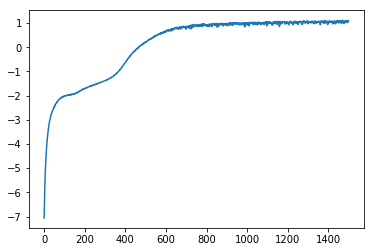

In [1257]:
plt.plot(range(epochs),loss_iter)

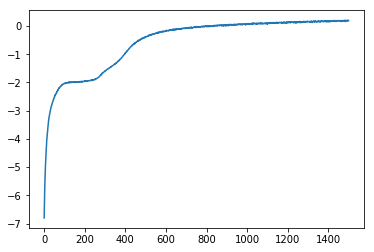

In [1242]:
plt.plot(range(epochs),loss_iter)

### generate new data via $p(x) = \int p(z)~p_{\theta}(x|z)~dz$

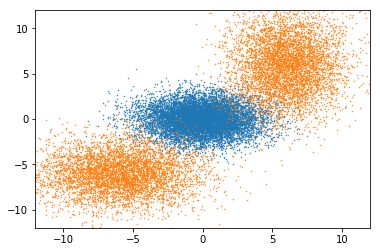

In [1258]:
sample = Variable(t.randn(10000, 20))
sample = model.decode_Gaussian(sample)
std = sample[1].exp_().sqrt()
sample_x1 = np.random.normal(0,1,10000) * std.data.numpy()[:,0] + sample[0].data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,10000) * std.data.numpy()[:,1] + sample[0].data.numpy().transpose()[1]
plt.ylim((-12,12))
plt.xlim((-12,12))
plt.scatter(sample_x1,sample_x2,s=0.2)
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

### generate new data via $p(x^{new}|x) = \int p(x^{new}|z)~p_{\theta}(z|x)~dz$

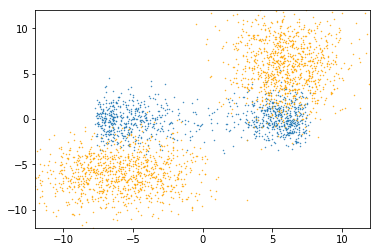

In [1259]:
for batch_idx, (data, _) in enumerate(GMM_loader):
    if batch_idx ==0:
        data = Variable(data)
        (mu_x, logvar_x), mu_z, logvar_z = model(data)
std = logvar_x.exp_().sqrt()
sample_x1 = np.random.normal(0,1,bsize) * std.data.numpy()[:,0] + mu_x.data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,bsize) * std.data.numpy()[:,1] + mu_x.data.numpy().transpose()[1]
plt.ylim((-12,12))
plt.xlim((-12,12))
plt.scatter(sample_x1,sample_x2,s=0.2)

plt.scatter(Variable(x).data.numpy().transpose()[0][0:1000],Variable(x).data.numpy().transpose()[1][0:1000],s=0.2,c='orange')
plt.scatter(Variable(x).data.numpy().transpose()[0][-1000:],Variable(x).data.numpy().transpose()[1][-1000:],s=0.2,c='orange')

### Again the second method generates data that better reconstructs the original data. 

In [ ]:
## 